In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision

### Dataset download and data processing

In [79]:
dataset = torchvision.datasets.MNIST('./data', train=True, download=True)

def create_subset(data, start, end):
    transform = torchvision.transforms.ToTensor()
    img_subset = []
    label_subset = []
    for i in range(start, end, 1):
        img, class_label =  data[i]
        img = transform(img)/255

        label = [0. for i in range(10)]
        label[class_label] = 1.

        img_subset.append(img)
        label_subset.append(label)

    return torch.cat(img_subset), torch.tensor(label_subset)

X_train, y_train = create_subset(dataset, 0, 45000)
X_validation, y_validation = create_subset(dataset, 45000, 50000)
X_test, y_test = create_subset(dataset, 50000, len(dataset))


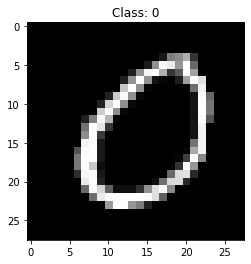

In [104]:
sample_img, img_class = dataset[np.random.randint(len(dataset))]

plt.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Class: {img_class}")
plt.show()

### Definition of the classification model

In [75]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, img_in):

        out = self.linear1(img_in.view(-1, 28*28))
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.softmax(out)

        return out


### Dataloaders, optimizer and loss function

In [80]:
b_size = 64

train_dataset = data_utils.TensorDataset(X_train, y_train)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=b_size)

validation_dataset = data_utils.TensorDataset(X_validation, y_validation)
validation_dataset = data_utils.DataLoader(validation_dataset, batch_size=b_size)

test_dataset =  data_utils.TensorDataset(X_test, y_test)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=b_size)

model = MnistNN()

lr = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)

loss_fn = nn.CrossEntropyLoss()

In [91]:
EPOCH_NUM = 100

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

train_accuracy = []
validation_accuracy = []

for epoch in range(EPOCH_NUM):
    loss_history = []
    for idx, (img, label) in enumerate(train_dataloader):
        
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        logits = model(img)
        loss = loss_fn(logits, label)

        loss_history.append(loss.item())
        if(epoch%10 == 0 and idx == len(train_dataloader)/b_size):
            print(f"Epoch: {epoch+1} -- Average loss: {sum(loss_history)/(len(train_dataloader)/b_size)}")

        loss.backward()
        optimizer.step()


Epoch: 1 -- Average loss: 1.9750176884911277
Epoch: 11 -- Average loss: 1.865833412517201
Epoch: 21 -- Average loss: 1.8272419517690486
Epoch: 31 -- Average loss: 1.797252600843256
Epoch: 41 -- Average loss: 1.7737259322946721
Epoch: 51 -- Average loss: 1.755177291956815
Epoch: 61 -- Average loss: 1.7383459589698098
Epoch: 71 -- Average loss: 1.724355621771379
Epoch: 81 -- Average loss: 1.714603846723383
Epoch: 91 -- Average loss: 1.7060258280147205


In [ ]:
model(torchvision.transforms.ToTensor()(sample_img))


### Bounding box calculation

In [9]:
def find_bbox(img):
    xs = ys = xe = ye = -1
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0:
                if(ys == -1):
                    ys = i
                if(xs == -1 or j < xs):
                    xs = j
                if(i > ye):
                    ye = i
                if(j > xe):
                    xe = j
    
    return (xs-1, ys-1, xe+1, ye+1)

7 1 23 22


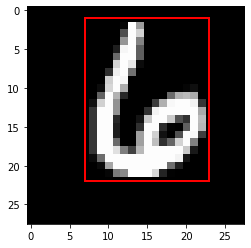

In [10]:
xs, ys, xe, ye = find_bbox(torchvision.transforms.PILToTensor()(sample_img)[0])
print(xs, ys, xe, ye)

fig, ax = plt.subplots()
ax.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
rect = patches.Rectangle((xs, ys), xe-xs, ye-ys, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()